In [21]:
# Imports
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA


from sklearn.model_selection import KFold
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE




### Import Data

In [22]:
# Load SP500 and US macroeconomic data from CSV files
data = pd.read_csv('./data/SP500_data/GOOGL.csv', parse_dates=['Date'])
macro_data = pd.read_csv('./data/SP500_data/US_macroeconomics.csv', parse_dates=['date'])

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)  # Set the date column as the index if not already set


print(data)

# Merge datasets on the date field
merged_data = pd.merge(data, macro_data, left_on='Date', right_on='date', how='outer')

# Handle missing values: forward fill then backward fill to cover all gaps
merged_data.interpolate(method='ffill', inplace=True)
merged_data.interpolate(method='bfill', inplace=True)

# Drop the extra date column to avoid duplication
merged_data.drop(columns=['date'], inplace=True)

# Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Select numerical features for scaling
numerical_features = ['Close', 'Volume', 'CPI', 'Mortgage_rate', 'Unemp_rate', 'NASDAQ', 'disposable_income', 'Personal_consumption_expenditure', 'personal_savings']
merged_data[numerical_features] = scaler.fit_transform(merged_data[numerical_features])

# Ensure all other non-numeric columns are excluded from the feature set
features = numerical_features  # This ensures only the scaled numeric features are used

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(merged_data[numerical_features].drop('Close', axis=1))

# Convert X_pca back to DataFrame for easier handling (optional, for clarity)
X_pca_df = pd.DataFrame(X_pca)

target_data = merged_data['Close']


def create_sequences(features, target, sequence_length=10):
    xs, ys = [], []
    for i in range(len(features) - sequence_length):
        x = features.iloc[i:(i + sequence_length)].values
        y = target.iloc[i + sequence_length]  # Directly use the target variable
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Create sequences using the PCA-transformed data and the separate target variable
X, y = create_sequences(X_pca_df, target_data)


# Print the explained variance ratio for each principal component
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio for each Principal Component:")
for i, variance in enumerate(explained_variance_ratio):
    print(f"Component {i+1}: {variance:.4f}")


                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2004-08-19    50.050049    52.082081    48.028027    50.220219    50.220219   
2004-08-20    50.555557    54.594597    50.300301    54.209209    54.209209   
2004-08-23    55.430431    56.796799    54.579578    54.754753    54.754753   
2004-08-24    55.675674    55.855858    51.836838    52.487488    52.487488   
2004-08-25    52.532532    54.054054    51.991993    53.053055    53.053055   
...                 ...          ...          ...          ...          ...   
2022-03-18  2668.489990  2724.879883  2645.169922  2722.510010  2722.510010   
2022-03-21  2723.270020  2741.000000  2681.850098  2722.030029  2722.030029   
2022-03-22  2722.030029  2821.000000  2722.030029  2797.360107  2797.360107   
2022-03-23  2774.050049  2791.770020  2756.699951  2765.510010  2765.510010   
2022-03-24  2784.000000  2832.379883  2755.010010  2

In [23]:
def create_sequences(data, sequence_length=10):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data.iloc[i:(i + sequence_length)].values
        y = data.iloc[i + sequence_length]['Close']
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, y = create_sequences(merged_data[features])

# Define split ratios
train_ratio = 0.7  # Adjusted to leave some data for testing
test_ratio = 0.3   # Adjusted accordingly

# Calculate indices for splitting
train_end = int(len(X) * train_ratio)
test_start = train_end  # Start of test data is the end of train data

# Split the data
X_train, y_train = X[:train_end], y[:train_end]
X_test, y_test = X[test_start:], y[test_start:]

# Display the shapes of the datasets
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (3347, 10, 9), (3347,)
Test set shape: (1435, 10, 9), (1435,)


In [24]:
def create_cnn_model(input_shape):
    """
    Function to create a Convolutional Neural Network (CNN) model that uses macroeconomic data
    and other properties to predict Google's stock price.
    
    Parameters:
    - input_shape (tuple): The shape of the input data (time_steps, features).
    
    Returns:
    - model: A compiled CNN model.
    """
    # Try Dropout
    model = Sequential([
        Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model



In [25]:
from keras.layers import Input, Dense, LSTM, Dropout, Reshape
from keras.models import Model
from keras.optimizers import Adam
import numpy as np
from imblearn.over_sampling import SMOTE

def build_generator():
    input = Input(shape=(100,))
    x = Dense(120)(input)
    x = Reshape((10, 12))(x)
    x = LSTM(50, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(50)(x)
    x = Dense(10 * 9, activation='linear')(x)
    x = Reshape((10, 9))(x)  # Reshape the final output to (10, 9)
    return Model(input, x)

def build_discriminator():
    input = Input(shape=(10, 9))
    x = LSTM(50, return_sequences=True)(input)
    x = Dropout(0.2)(x)
    x = LSTM(50)(x)
    x = Dense(1, activation='sigmoid')(x)
    return Model(input, x)

generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
gan_input = Input(shape=(100,))
fake_data = generator(gan_input)
discriminator.trainable = False
validity = discriminator(fake_data)
gan = Model(gan_input, validity)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
gan.summary()

def train_gan(generator, discriminator, gan, X_train, epochs=100, batch_size=32):
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_data = X_train[idx]
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_data = generator.predict(noise)
        d_loss_real = discriminator.train_on_batch(real_data, valid)
        d_loss_fake = discriminator.train_on_batch(gen_data, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, valid)
        print(f"Epoch: {epoch} [D loss: {d_loss}] [G loss: {g_loss}]")

def generate_synthetic_data(generator, n_samples=1000):
    noise = np.random.normal(0, 1, (n_samples, 100))
    return generator.predict(noise)

def generate_synthetic_data_with_smote(X, n_samples=1000):
    n_features = X.shape[1] * X.shape[2]
    X_flat = X.reshape(-1, n_features)
    smote = SMOTE(sampling_strategy='minority')
    X_resampled, _ = smote.fit_resample(X_flat, [0] * len(X_flat))
    return X_resampled.reshape(-1, X.shape[1], X.shape[2])

synthetic_data = generate_synthetic_data(generator, n_samples=1000)
print("Synthetic Data Generated:", synthetic_data.shape)


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_8 (Functional)       │ (None, 10, 9)          │        49,510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_10 (Functional)      │ (None, 1)              │        32,251 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,761 (319.38 KB)

 Trainable params: 49,510 (193.40 KB)

 Non-trainable params: 32,251 (125.98 KB)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Synthetic Data Generated: (1000, 10, 9)


import pandas as pd
import numpy as np
from keras.layers import Input, Dense, LSTM, Dropout, Reshape
from keras.models import Model
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

# Define a placeholder for the preprocess_data function
def preprocess_data(X):
    # Assuming preprocessing involves normalization
    scaler = MinMaxScaler()
    return scaler.fit_transform(X.reshape(-1, 1)).reshape(X.shape)

# GAN setup
def build_generator():
    input = Input(shape=(100,))
    x = Dense(120)(input)
    x = Reshape((10, 12))(x)
    x = LSTM(50, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(50)(x)
    x = Dense(10 * 4, activation='linear')(x)
    x = Reshape((10, 4))(x)
    return Model(input, x)

def build_discriminator():
    input = Input(shape=(10, 4))
    x = LSTM(50, return_sequences=True)(input)
    x = Dropout(0.2)(x)
    x = LSTM(50)(x)
    x = Dense(1, activation='sigmoid')(x)
    return Model(input, x)

generator = build_generator()
discriminator = build_discriminator()

# Make discriminator trainable for standalone training
discriminator.trainable = True
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Assemble GAN
gan_input = Input(shape=(100,))
fake_data = generator(gan_input)
discriminator.trainable = False  # Ensure discriminator is not trainable when training GAN
validity = discriminator(fake_data)
gan = Model(gan_input, validity)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

def train_gan(generator, discriminator, gan, X_train, y_train, epochs=100, batch_size=32):
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_data = X_train[idx]
        real_labels = y_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_data = generator.predict(noise)

        # Train discriminator
        d_loss_real = discriminator.train_on_batch(real_data, valid)
        d_loss_fake = discriminator.train_on_batch(gen_data, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, valid)

        print(f"Epoch: {epoch} [D loss: {d_loss}] [G loss: {g_loss}]")

def generate_synthetic_data(generator, n_samples=1000):
    noise = np.random.normal(0, 1, (n_samples, 100))
    return generator.predict(noise)

def generate_synthetic_data_with_smote(X, n_samples=1000):
    n_features = X.shape[1] * X.shape[2]
    X_flat = X.reshape(-1, n_features)
    smote = SMOTE(sampling_strategy='minority')
    X_resampled, _ = smote.fit_resample(X_flat, [0] * len(X_flat))
    return X_resampled.reshape(-1, X.shape[1], X.shape[2])

def evaluate_data(real_data, synthetic_data):
    n_features = real_data.shape[1] * real_data.shape[2]
    real_data_flat = real_data.reshape(-1, n_features)
    synthetic_data_flat = synthetic_data.reshape(-1, n_features)

    accuracy = accuracy_score(real_data_flat, synthetic_data_flat)
    precision = precision_score(real_data_flat, synthetic_data_flat, average='macro')
    recall = recall_score(real_data_flat, synthetic_data_flat, average='macro')
    f1 = f1_score(real_data_flat, synthetic_data_flat, average='macro')

    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

try:
    # Ensure preprocessed data
    X_train_normalized = preprocess_data(X_train)

    # Train the GAN
    train_gan(generator, discriminator, gan, X_train_normalized, y_train, epochs=100, batch_size=32)

    # Generate synthetic data
    synthetic_data = generate_synthetic_data(generator, n_samples=1000)

    # Evaluate synthetic data
    evaluate_data(X_train_normalized, synthetic_data)

    print("Synthetic Data Generated:", synthetic_data.shape)
except Exception as e:
    print("Error:", e)


In [26]:

sequence_length = 10  # You can adjust this based on your specific time series analysis needs


# Create the CNN model
model = create_cnn_model(input_shape=(sequence_length, len(features)))
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Assuming y_pred is already computed
y_pred = model.predict(synthetic_data)

# Calculate regression metrics
#mse = mean_squared_error(y_test, y_pred)
#mae = mean_absolute_error(y_test, y_pred)
#r2 = r2_score(y_test, y_pred)

#print(f"Mean Squared Error: {mse}, Mean Absolute Error: {mae}, R^2 Score: {r2}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 5, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,937 (656.00 KB)

 Trainable params: 167,937 (656.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0088 - mae: 0.0613
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.9288e-04 - mae: 0.0234
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.1875e-04 - mae: 0.0197
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6035e-04 - mae: 0.0170
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8781e-04 - mae: 0.0159
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1726e-04 - mae: 0.0144
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5203e-04 - mae: 0.0133
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9837e-04 - mae: 0.0122
Epoch 9/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1674e-04 - mae: 0.0123
Epoch 10/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0121e-04 - mae: 0.0122
Epoch 11/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0100e-04 - mae: 0.0122
Epoch 12/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3439

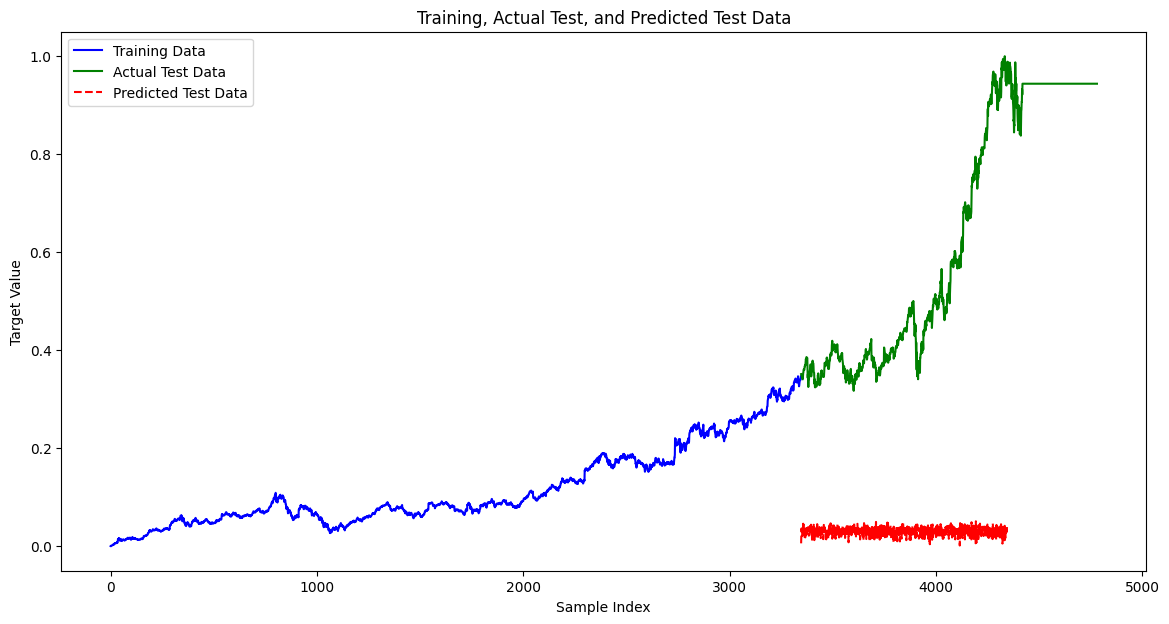

In [27]:
import matplotlib.pyplot as plt

# Plotting the actual vs predicted values
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(range(len(y_train)), y_train, label='Training Data', color='blue')

# Plot test data
test_data_start_index = len(y_train)
test_data_end_index = test_data_start_index + len(y_test)
plt.plot(range(test_data_start_index, test_data_end_index), y_test, label='Actual Test Data', color='green')

# Plot predicted data
predicted_data_start_index = test_data_start_index
predicted_data_end_index = predicted_data_start_index + len(y_pred)
plt.plot(range(predicted_data_start_index, predicted_data_end_index), y_pred, label='Predicted Test Data', color='red', linestyle='--')

plt.title('Training, Actual Test, and Predicted Test Data')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()

# ARIMA model

Date
2004-08-19      50.220219
2004-08-20      54.209209
2004-08-23      54.754753
2004-08-24      52.487488
2004-08-25      53.053055
                 ...     
2022-03-18    2722.510010
2022-03-21    2722.030029
2022-03-22    2797.360107
2022-03-23    2765.510010
2022-03-24    2831.439941
Name: Close, Length: 4431, dtype: float64


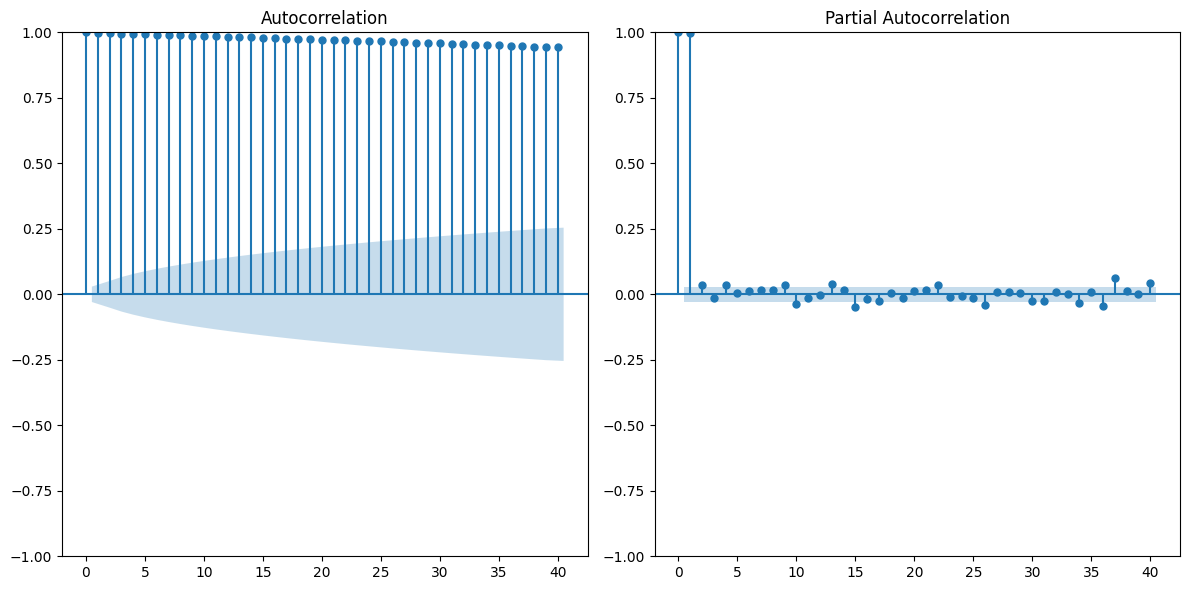

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4431
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -18566.629
Date:                Wed, 01 May 2024   AIC                          37145.257
Time:                        17:48:27   BIC                          37183.634
Sample:                             0   HQIC                         37158.791
                               - 4431                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0603      0.006     -9.585      0.000      -0.073      -0.048
ar.L2          0.0136      0.006      2.178      0.029       0.001       0.026
ar.L3         -0.0529      0.006     -9.170      0.0

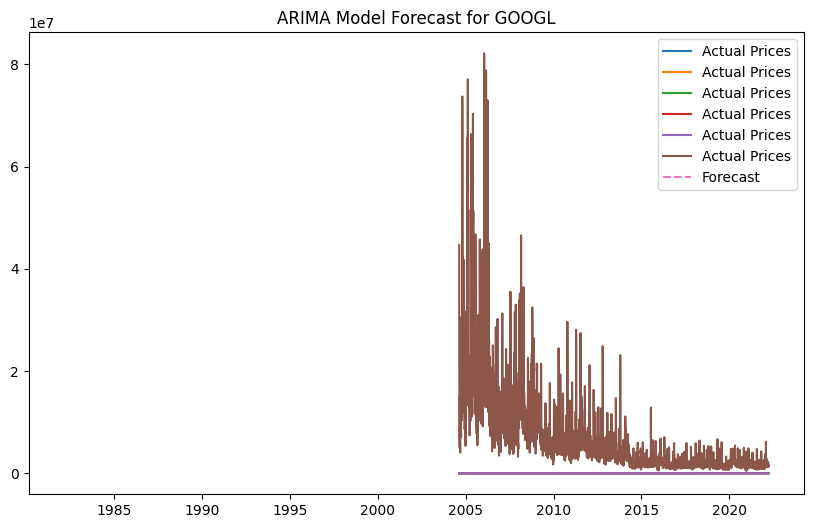

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

warnings.filterwarnings('ignore')


# Plot ACF and PACF
def plot_acf_pacf(data, lags=40):
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(data, lags=lags, ax=plt.gca())
    plt.subplot(122)
    plot_pacf(data, lags=lags, ax=plt.gca())
    plt.tight_layout()
    plt.show()

# Build and fit ARIMA model
def build_arima_model(data, order=(5, 1, 0)):
    model = ARIMA(data, order=order)
    fitted_model = model.fit()
    return fitted_model

# Forecast future prices
def forecast_stock(model, steps=5):
    forecast = model.get_forecast(steps=steps)
    forecast_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()
    
    return forecast_mean, conf_int



numeric_series = data['Close']  # Ensure this is the numeric column you want to model

print(numeric_series)

# Visualize ACF and PACF
plot_acf_pacf(data['Close'], lags=40)

# Build and fit ARIMA model
model = build_arima_model(data['Close'])
print(model.summary())

# Forecast future prices
forecast_mean, conf_int = forecast_stock(model, steps=10)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(data, label="Actual Prices")
plt.plot(forecast_mean.index, forecast_mean, label="Forecast", linestyle='--')
plt.fill_between(forecast_mean.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], alpha=0.3)

plt.legend()
plt.title(f"ARIMA Model Forecast for GOOGL")
plt.show()

0      114.124123
1      113.123123
2      114.014015
3      115.760757
4      114.474472
          ...    
315    189.164169
316    190.690689
317    188.658661
318    187.287292
319    184.434433
Name: Close, Length: 320, dtype: float64


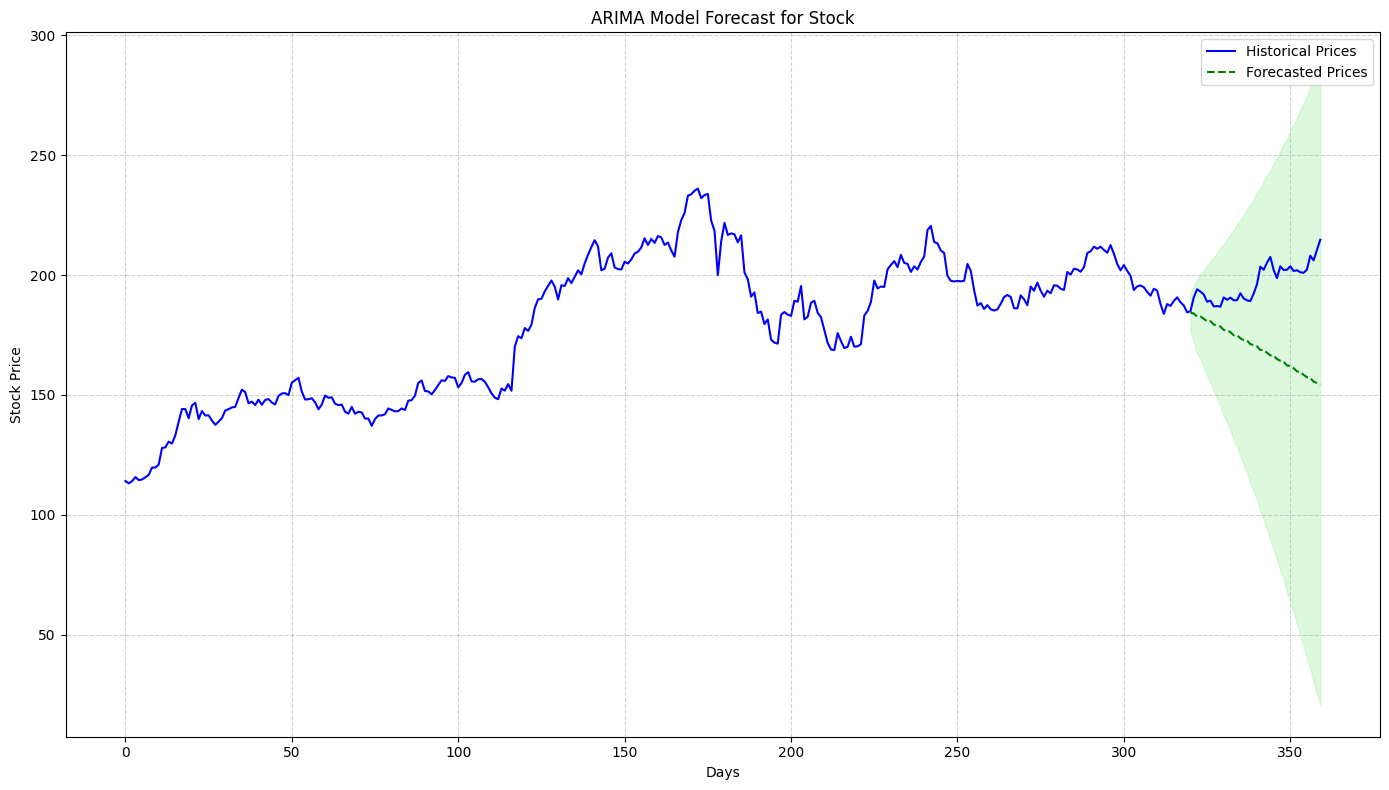

In [132]:
def build_arima_model(data, order=(3, 4, 9)):
    model = ARIMA(data, order=order)
    fitted_model = model.fit()
    return fitted_model
def forecast_and_simulate_stock(model, steps=30):
    # Get the forecast result
    forecast_result = model.get_forecast(steps=steps)
    forecast_mean = forecast_result.predicted_mean

    # Convert MultiIndex DataFrame to standard column format
    conf_intervals = forecast_result.conf_int()
    conf_intervals.columns = ['lower', 'upper']

    return forecast_mean, conf_intervals

startRow = 180
stopRow = 500
steps = 40

# Assuming the 'Close' column contains stock closing prices
numeric_series = data['Close'].iloc[startRow:stopRow]

numeric_series.reset_index(drop=True, inplace=True)
print(numeric_series)

numeric_series2 = data['Close'].iloc[startRow:(stopRow + steps)]
numeric_series2.reset_index(drop=True, inplace=True)


# Build ARIMA model
model = build_arima_model(numeric_series)

# Simulate future prices
forecast_series, conf_df = forecast_and_simulate_stock(model, steps)

# Visualization
plt.figure(figsize=(14, 8))

# Plot historical data
plt.plot(numeric_series2, label="Historical Prices", color='blue')

# Plot forecasted data
forecast_index = np.arange(len(numeric_series), len(numeric_series) + len(forecast_series))
plt.plot(forecast_index, forecast_series, label="Forecasted Prices", linestyle='--', color='green')

# Fill between for confidence intervals
plt.fill_between(forecast_index, conf_df['lower'], conf_df['upper'], alpha=0.3, color='lightgreen')

# Add gridlines for clarity
plt.grid(True, linestyle='--', alpha=0.6)

# Add labels and legend
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.legend()

# Title and show plot
plt.title("ARIMA Model Forecast for Stock")
plt.tight_layout()
plt.show()

In [151]:
# ARIMAX model with external regressors
def build_arimax_model(data, exog, order=(5, 1, 0)):
    """
    Builds an ARIMAX model using the given time series and external regressors.

    Parameters:
    - data: Time series data (stock prices or another primary time series).
    - exog: External regressors in a DataFrame format.
    - order: Tuple specifying the ARIMA order (p, d, q).
    
    Returns:
    - A fitted ARIMAX model.
    """
    model = ARIMA(data, order=order, exog=exog)
    fitted_model = model.fit()
    return fitted_model


def forecast_and_simulate_stock(model, exog_future, steps=30):
    """
    Forecasts future stock prices using the fitted ARIMAX model and external regressors.

    Parameters:
    - model: A fitted ARIMAX model.
    - exog_future: Future values of external regressors.
    - steps: Number of steps to forecast.
    
    Returns:
    - A tuple with the forecasted mean series and confidence intervals.
    """
    forecast_result = model.get_forecast(steps=steps, exog=exog_future)
    forecast_mean = forecast_result.predicted_mean

    conf_intervals = forecast_result.conf_int()
    conf_intervals.columns = ['lower', 'upper']

    return forecast_mean, conf_intervals

startRow = 180
stopRow = 200
steps = 30

merged_data2 = pd.merge(data, macro_data, left_on='Date', right_on='date', how='outer')

# Handle missing values: forward fill then backward fill to cover all gaps
merged_data2.interpolate(method='ffill', inplace=True)
merged_data2.interpolate(method='bfill', inplace=True)


print(numeric_series);
print(macroeconomic_data)


numeric_series2 = merged_data2['Close'].iloc[startRow:(stopRow + steps)]
numeric_series2.reset_index(drop=True, inplace=True)

macroeconomic_data = merged_data2[['CPI', 'Mortgage_rate']]  # Replace with relevant indicators

print(macroeconomic_data)

exog_future = pd.DataFrame({
    'CPI': np.linspace(merged_data2['CPI'].mean(), merged_data2['CPI'].mean(), 30),
    'Mortgage_rate': np.linspace(merged_data2['Mortgage_rate'].mean(), merged_data2['Mortgage_rate'].mean(), 30),
})



# Build ARIMA model
model = build_arimax_model(numeric_series, macroeconomic_data)

# Simulate future prices
forecast_series, conf_df = forecast_and_simulate_stock(model, steps)

# Visualization
plt.figure(figsize=(14, 8))

# Plot historical data
plt.plot(numeric_series2, label="Historical Prices", color='blue')

# Plot forecasted data
forecast_index = np.arange(len(numeric_series), len(numeric_series) + len(forecast_series))
plt.plot(forecast_index, forecast_series, label="Forecasted Prices", linestyle='--', color='green')

# Fill between for confidence intervals
plt.fill_between(forecast_index, conf_df['lower'], conf_df['upper'], alpha=0.3, color='lightgreen')

# Add gridlines for clarity
plt.grid(True, linestyle='--', alpha=0.6)

# Add labels and legend
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.legend()

# Title and show plot
plt.title("ARIMA Model Forecast for Stock")
plt.tight_layout()
plt.show()



0     114.124123
1     113.123123
2     114.014015
3     115.760757
4     114.474472
5     114.734734
6     115.640640
7     116.681679
8     119.699699
9     119.709709
10    120.925926
11    127.852852
12    128.128128
13    130.535538
14    129.729736
15    133.133133
16    138.773773
17    144.144150
18    144.094101
19    140.270264
Name: Close, dtype: float64
      CPI  Mortgage_rate
0   153.7         7.3775
1   153.9         7.2000
2   154.7         7.0300
3   155.0         7.0750
4   155.5         7.6240
5   156.1         7.9250
6   156.4         8.0700
7   156.7         8.3200
8   157.0         8.2450
9   157.2         8.0020
10  157.7         8.2300
11  158.2         7.9150
12  158.7         7.6180
13  159.1         7.5975
14  159.4         7.8240
15  159.7         7.6500
16  159.8         7.8975
17  159.9         8.1425
18  159.9         7.9440
19  160.2         7.6900
          CPI  Mortgage_rate
0     189.800         5.7540
1     189.800         5.7540
2     189.800       

ValueError: The indices for endog and exog are not aligned